# <font color="darkblue"> Projeto 01 - Reconhecimento de Dígitos</font>

**Objetivos**

Implementar três classificadores de dígitos contidos no dataset MNIST Adaptado, utilizando
os três modelos lineares de Aprendizagem de Máquina (AM) estudados: Perceptron, Regressão
Linear e Regressão Logística.

**Dataset MNIST adaptado**

Os arquivos train.csv e test.csv contêm imagens do dataset MNIST, em escala de cinza, dos
dígitos 0, 1, 4 e 5 escritos a mão. Cada imagem é composta por 28 linhas e 28 colunas em um
total de 784 pixels. Cada pixel possui um valor associado único, que indica seu tom de cinza.
Quanto mais alto é esse valor, mais escuro é o pixel. Os valores de cada pixel estão no intervalo
fechado [0, 255].

Os dados de entrada, (train.csv), possuem 785 colunas. A primeira coluna, chamada “label”,
é o dígito que foi desenhado pelo usuário. O resto das colunas contém os valores dos pixels da
imagem associada.

Cada coluna de pixel, nos dados de treino, é nomeada como “pixel𝑥”, onde 𝑥 é um inteiro
no intervalo [0, 783]. Para localizar este pixel na imagem, suponha que decompomos 𝑥 como
𝑥 = 𝑖 ∗ 28 + 𝑗, onde 𝑖 e 𝑗 são inteiros no intervalor [0, 27]. Então o “pixel𝑥” está localizado nalinha 𝑖 e coluna 𝑗 de uma matriz 28𝑥28 (indexada por zero). Por exemplo, “pixel31” indica o valor do pixel que está na quarta coluna, da esquerda pra direita, e na segunda linha.

Os dados de teste, (test.csv), possuem o mesmo formato dos dados de treinamento.

# <font color="darkblue"> Solução </font>

**Importação do dataset**

In [1]:
import numpy as np

data_path = "dataset_digits/"
train = np.genfromtxt(data_path + "train.csv", delimiter=";")
test = np.genfromtxt(data_path + "test.csv", delimiter=";")

# Rm first line of labels
train = train[1:]
test = test[1:]

0
28


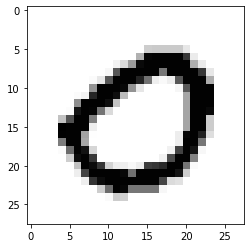

In [2]:
import matplotlib.pyplot as plt
        
dim = 28

def get_images_and_labels(data):
    delta = 1 # image label
    X = np.empty(shape=(len(data), dim, dim))
    # X = np.empty(shape=(len(data), dim * dim))
    y = np.empty(len(data), dtype=int)
    for i, img in enumerate(data):
        # x = 28i + j
        X[i] = [[img[delta + 28*i + j] for i in range(dim)] for j in range(dim)]
        # X[i] = [img[delta + i] for i in range(len(img) - 1)]
        y[i] = int(img[0])

    return X, y

train_X, train_y = get_images_and_labels(train)
test_X, test_y = get_images_and_labels(test)

print(train_y[0])
print(train_X.shape[1])
plt.imshow(train_X[0], cmap="Greys")
plt.show()

**Redução da dimensão da amostra**

Para trabalharmos com modelos de AM que possuem muito pouco grau de liberdade
para a construção de sua função hipótese, devemos diminuir a complexidade dos dados de
entrada através da redução do número de parâmetros 𝑝 das amostras de treinamento.

Como já foi dito na descrição do dataset, cada instância é composta por 𝑝 = 784
parâmetros de entrada, sendo um parâmetro por pixel. Logo, há a necessidade de reduzir a
quantidade de parâmetros total, a fim de atingir bons resultados na classificação das de tais
imagens usando-se modelos de AM mais simples. Uma forma de reduzir consideravelmente
o vetor de características é sintetizar os dados das imagens em apenas duas informações de
entrada (𝑝 = 2) que são muito importantes na identificação de um dígito numérico: a
intensidade e a simetria da imagem.

**Cálculo de intensidade e simetria das imagens**


Intensidade             |  Simetria Vertical
:-------------------------:|:-------------------------:
<img title="" alt="" width="350" src="I.png">  |  <img title="" alt="" width="350" src="Sv.png">

<!-- <p float="left">
<img title="" alt="" width="350" src="I.png">
<img title="" alt="" width="350" src="Sv.png">
</p> -->

In [3]:
def comp_intensity(x):
    return np.sum(x) / 255.0
            
def comp_vsymmetry(x):
    Sv = 0.0
    for i in range(dim):
        for j in range(int(dim / 2)):
            Sv += abs(x[i, j] - x[i, dim - 1 - j])
    return Sv / 255.0

def comp_hsymmetry(x):
    Sh = 0.0
    for i in range(int(dim / 2)):
        for j in range(dim):
            Sh += abs(x[i, j] - x[dim - 1 - i, j])
    return Sh / 255.0

def comp_symmetry(x):
    return comp_vsymmetry(x) + comp_hsymmetry(x)

**Construção de novos arquivos**

Nesta atividade, deve-se construir novos arquivos de treino e teste a serem chamados
de train_redu.csv e test_redu.csv. Esses arquivos conterão as seguintes colunas: label,
intensidade e simetria. 

In [4]:
def normalize(data, j):
    """
    Normaliza os dados da coluna j entre 0 e 1.
    """
    a = min(data, key=lambda x: x[j])[j]
    b = max(data, key=lambda x: x[j])[j]
    d = b - a
    for i, x in enumerate(data):
        data[i][j] = (data[i][j] - a) / d

def comp_redu(data, labels):
    """
    Computa a versão reduzida dos dados, transformando o label + 784 parâmetros de intensidade de pixel em (label, intensidade, simetria).
    Os dados retornados estão normalizados entre 0 e 1.
    """
    X = np.empty(shape=(len(data), 3))
    for i, x in enumerate(data):
        X[i] = [labels[i], comp_intensity(x), comp_symmetry(x)]
    normalize(X, 1)
    normalize(X, 2)
    return X

train_redu = comp_redu(train_X, train_y)
test_redu = comp_redu(test_X, test_y)

**Classificação dos dígitos 1 x 5**
    
Como no modelo Perceptron a classificação é binária, uma alternativa para realizar
classificações multiclasse de dígitos é construir, inicialmente, uma solução que classifique
apenas dois valores de dígitos: 1 e 5, por exemplo. Para isto, deve-se:

- Realizar um filtro nos dados dos arquivos train_redu.csv e test_redu.csv, deixando
apenas as imagens com valores 1 ou 5 na coluna label, construindo as instâncias
train1x5 e test1x5;
- Plotar os dados de train1x5 em um gráfico de duas dimensões (intensidade X
simetria) como ilustrado na Figura 4. Dados com 𝑙𝑎𝑏𝑒𝑙 = 1 plotar de azul e dados
com 𝑙𝑎𝑏𝑒𝑙 = 5 plotar de vermelho;

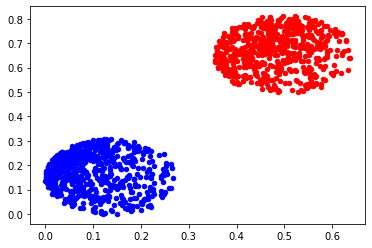

In [5]:
def filter(data, digits):
    """
    Retorna os dados cujos labels são iguais a algum dos valores em digits.
    """
    X = np.empty(shape=(0,3))
    for i, x in enumerate(data):
        for _, d in enumerate(digits):
            if x[0] == d:
                X = np.append(X, [x], axis=0)
                break
    return X

def plot_data(data, digits):
    """
    Plota os dados cujos labels são iguais a algum dos valores em digits.
    """
    N = data.shape[0]
    for i, d in enumerate(digits):
        color = 'blue'
        if i > 0:
            color = 'red'
        x = [data[i][1] for i in range(N) if data[i][0] == d]
        y = [data[i][2] for i in range(N) if data[i][0] == d]
        plt.scatter(x, y, color=color, marker='o', s=20)
    # plt.show()

digits = [1, 5]
train1x5 = filter(train_redu, digits)

plot_data(train1x5, digits)

- Treinar os três classificadores com os dados de train1x5. Construir o vetor 𝑋 =
{(𝑖𝑛𝑡𝑒𝑛𝑠𝑖𝑑𝑎𝑑𝑒, 𝑠𝑖𝑚𝑒𝑡𝑟𝑖𝑎)} para toda imagem de train1x5. Atribuir o valor alvo
𝑦 = +1 para a imagem com valor 𝑙𝑎𝑏𝑒𝑙 = 1 e 𝑦 = −1 para 𝑙𝑎𝑏𝑒𝑙 = 5;

In [6]:
import classifiers as cls

def get_Xy(data, digits):
    """
    Retorna o label 1 para digits[0] e -1 para os demais.
    """
    N = data.shape[0]
    X = np.array(data[:,1:3])
    X = np.insert(X, 0, 1, axis=1)
    y = np.where(data[:,0] == digits[0], 1, -1)
    return X, y

X, y = get_Xy(train1x5, digits)

# pla = cls.Perceptron()
# a = pla.fit(X, y)
# print(pla.get_w())

# lir = cls.LinearRegression()
# lir.fit(X, y)
# print(lir.get_w())

# lor = cls.LogisticRegression()
# lor.fit(X, y)
# print(lor.get_w())

- Construir o vetor 𝑋 = {(𝑖𝑛𝑡𝑒𝑛𝑠𝑖𝑑𝑎𝑑𝑒, 𝑠𝑖𝑚𝑒𝑡𝑟𝑖𝑎)} para toda imagem de test1x5.
Atribuir o valor alvo 𝑦 = 𝑙𝑎𝑏𝑒𝑙 para cada imagem de test1x5;
- Testar os três classificadores com os dados de test1x5;
- Plotar a reta de cada classificador sobre os dados;

In [7]:
def plot_f(cls, color, label):
    x_p = [0, 1]
    y_p = [cls.get_y(x_p[0]), cls.get_y(x_p[1])]
    plt.plot(x_p, y_p, c=color, label=label)
    plt.legend()

In [8]:
# test1x5 = filter(test_redu, digits)

# X, y = get_Xy(test1x5, digits)

# pla_y = pla.predict(X)
# lir_y = lir.predict(X)
# lor_y = lor.predict(X)

# plot_data(test1x5, digits)

# plot_f(pla, 'black', 'PLA')
# plot_f(lir, 'orange', 'LIR')
# plot_f(lor, 'green', 'LOR')

- Gerar a matriz de confusão e os relatórios de eficácia de classificação de cada
classificador.

In [9]:
def get_reports(y_f, h):
    """
    Calcula a matriz de confusão e o relatório de eficácia de classificação contendo: acurácia, precisão, recall e f1 score.
    """
    vn = 0 # verdadeiros negativos
    fp = 0 # falsos positivos
    fn = 0 # falsos negativos
    vp = 0 # verdadeiros positivos
    for i, y in enumerate(y_f):
        if y == -1 and h[i] == -1:
            vn += 1
        elif y == -1 and h[i] == 1:
            fp += 1
        elif y == 1 and h[i] == -1:
            fn += 1
        else:
            vp += 1
    acuracia = (vp + vn) / (vp + vn + fp + fn)
    precisao = vp / (vp + fp)
    recall = vp / (vp + fn)
    f1score = 2 * precisao * recall / (precisao + recall)
    print(acuracia, precisao, recall, f1score)

    mat_conf = {
        'verdadeiro-negativo': vn,
        'falso-positivo': fp,
        'falso-negativo': fn,
        'verdadeiro-positivo': vp
    }

In [10]:
# get_reports(y, pla_y)
# get_reports(y, lir_y)
# get_reports(y, lor_y)

**Classificador de dígitos completo**

Para construir um classificador para os quatro dígitos contidos na base, deve-se
implementar uma estratégia conhecida como “um contra todos”. Nessa estratégia,
inicialmente, escolhe-se o dígito 0 para ser a classe 𝑦 = +1 e todas os outros dígitos (1, 4 e 5), temporariamente, definidos como a classe 𝑦 = −1. Essa transformação está ilustrada na
Figura 5.

A função hipótese 𝑓0 é inferida pelos novos dados de treino e usada para classificar os
dados de teste. Se 𝑓0 classificar o novo dado como da classe +1, então podemos afirmar
que a imagem associada é do dígito 0. Se o dado for classificado como −1, nada pode ser
afirmado. O próximo passo é criar uma nova instância de treino, eliminando as instâncias
com label=0, e construindo uma classificação binária do dígito 1 contra todos.
Ao final serão construídas três funções hipótese que juntas irão realizar a classificação
multiclasse dos quatro dígitos. Seja 𝑥 a imagem teste a ser classificada, classifique 𝑥 com o
seguinte algoritmo:

<img title="" alt="" width="350" src="classificador.png">

In [11]:
import time

class Classifier:
    def __init__(self, classifier):
        self.cls = classifier
        self.f = []
        self.digits = [0, 1, 4, 5]

    def fit(self, data, w=np.zeros((3), float)):
        d = len(self.digits)
        colors = ['black', 'green', 'orange']
        for i, _ in enumerate(self.digits[0:d-1]):
            train = filter(data, self.digits[i:d])
            plot_data(train, self.digits[i:d])
            X, y = get_Xy(train, self.digits[i:d])
            f = self.cls()
            f.fit(X, y, w)
            plot_f(f, colors[i], label=i)
            plt.show()
            self.f.append(f)

    def predict(X):
        p = []
        for x in X:
            for i, _ in enumerate(self.digits[0:d - 1]):
                if self.f[i].predict([x]) == [1]:
                    p.append(self.digits[i])
                elif i == d - 2:
                    p.append(self.digits[d - 1])

    def set_digits(self, new_digits):
        self.digits = new_digits

    def get_w(self, i):
        return self.f[i].get_w()

In [12]:
# import random

# class PocketLearningAlgorithm:
#     # def PLA(X, y, f):
#     def fit(self, X, y, w=np.zeros((3), float)):
#         """
#         Esta função corresponde ao Algoritmo de Aprendizagem do modelo Perceptron.
        
#         Paramêtros:
#         - X (list[]): Matriz correspondendo aos dados amostra. Cada elemento de X é uma lista que corresponde 
#         às coordenadas dos pontos gerados.
#         - y (list): Classificação dos pontos da amostra X.
#         - f (list): Lista de dois elementos correspondendo, respectivamente, aos coeficientes angular e linear 
#         da função alvo.
        
#         Retorno:
#         - it (int): Quantidade de iterações necessárias para corrigir todos os pontos classificados incorretamente.
#         - w (list): Lista de três elementos correspondendo aos pesos do perceptron.
#         """
#         it = 0
#         # w = np.zeros((3), float)
#         listaPCI = self.constroiListaPCI(X, y, w)
#         # i = self.iPrimeiroIncorreto(X, y, w)
#         # while (len(listaPCI) > 0):
#         N = 100 * len(X)
#         best_nb_incorrects = len(listaPCI)
#         self.w = w.copy()
#         while it < N and len(listaPCI) > 0:
#             # Escolha aleatoriamente um ponto xi pertencente à lista
#             i = listaPCI[random.randint(0, len(listaPCI) - 1)]
#             # i = self.iPrimeiroIncorreto(X, y, w)
#             # if i < 0:
#             #     break
            
#             # Atualiza o vetor de pesos ao corrigir a classificação de x
#             w[0] += y[i]
#             w[1:3] += y[i] * X[i][1:3]

#             # Atualiza o melhor classificador encontrado.
#             if len(listaPCI) < best_nb_incorrects:
#                 best_nb_incorrects = len(listaPCI)
#                 self.w = w.copy()

#             # Aqui você deverá contruir a lista de pontos classificados incorretamente
#             listaPCI = self.constroiListaPCI(X, y, w) 
            
#             # Após atualizar os pesos para correção do ponto escolhido, você irá chamar a função plotGrafico()
#             # plot_grafico(X, y, w, f) 

#             it += 1
        
#         self.it = it
     
#     def predict(self, X):
#         """
#         Classifica os dígitos em X.
#         """
#         return [1 if iseq(np.sign(self.w[0]*x[0] + self.w[1]*x[1] + self.w[2]*x[2]), 1) else -1 for x in X]
#         # return [np.sign(self.w[0]*x[0] + self.w[1]*x[1] + self.w[2]*x[2]) for x in X]
     
#     def get_w(self):
#         return self.w
    
#     def constroiListaPCI(self, X, y, w):
#         """
#         Esta função constrói a lista de pontos classificados incorretamente.
        
#         Paramêtros:
#         - X (list[]): Matriz correspondendo aos dados amostra. Cada elemento de X é uma lista que corresponde 
#         às coordenadas dos pontos gerados.
#         - y (list): Classificação dos pontos da amostra X.
#         - w (list): Lista correspondendo aos pesos do perceptron.
    
#         Retorno:
#         - l (list): Lista com os pontos classificador incorretamente.
#         - new_y (list): Nova classificação de tais pontos.
    
#         """    
#         # Substituição para melhorar a eficiência do algoritmo. Na versão anterior, 10N já era muito lento.
#         return np.where(np.sign(w[0]*X[:,0] + w[1]*X[:,1] + w[2]*X[:,2]) != y)[0]
#         # l = []
#         # for i, x in enumerate(X):
#         #     hx = np.sign(w[0]*x[0] + w[1]*x[1] + w[2]*x[2])
#         #     if hx != y[i]:
#         #         l.append(i)
#         # print("l2:", l)
#         # return l
    
#     def iPrimeiroIncorreto(self, X, y, w):
#         """
#         Retorna o índice do primeiro ponto classificado incorretamente.
#         """    
#         # new_y = []
#         for i, x in enumerate(X):
#             hx = np.sign(w[0]*x[0] + w[1]*x[1] + w[2]*x[2])
#             # print(hx, y[i], hx != y[i])
#             if hx != y[i]:
#                 return i
                
#         # return l, new_y
#         return -1
    
#     def get_y(self, x, shift=0):
#         """
#         Dado um valor de x, computa o valor de y.
#         """
#         return (-self.w[0]+shift - self.w[1]*x) / self.w[2]

# cls_pla = Classifier(PocketLearningAlgorithm)
# cls_pla.fit(train_redu)

# # cls_pla = Classifier(cls.LinearRegression)
# # cls_pla.fit(train_redu)

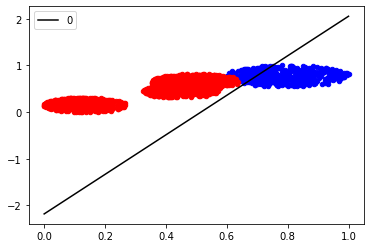

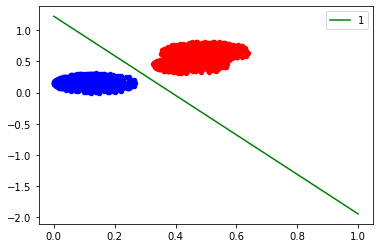

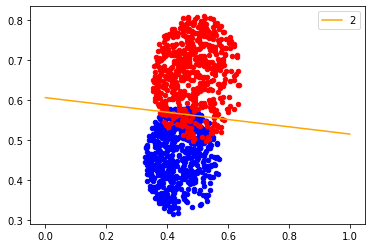

In [13]:
cls_pla = Classifier(cls.LinearRegression)
cls_pla.fit(train_redu)

In [14]:
cls_pla = Classifier(PocketLearningAlgorithm)
cls_pla.fit(train_redu)

NameError: name 'PocketLearningAlgorithm' is not defined

In [ ]:
cls_pla = Classifier(cls.LogisticRegression)
cls_pla.fit(train_redu)

**Implementações avançadas**

- Implementar a estratégia de “um contra todos” definindo a ordem de teste dos dígitos
que leve à melhor acurácia global. Ou seja, a ordem proposta anteriormente pode ser
alterada para uma ordem arbitrária que produza uma melhor acurácia de classificação.

In [ ]:
Ir rodando o fit, calculando a acurácia e guardando o melhor